In [ ]:
from google.colab import  drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, decode_image, ImageReadMode
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from  PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from typing import Iterable, Tuple

In [ ]:
sns.set_style("whitegrid")

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"No of devices - {torch.cuda.device_count()}")
    print(f"Device - {torch.cuda.get_device_name()}")

else:
    device = torch.device("cpu")

No of devices - 1
Device - Tesla T4


In [ ]:
IMAGES_PATH = Path("/content/drive/MyDrive/farm_insects")
encoder = LabelEncoder()

def create_images_df() -> pd.DataFrame:
    dfs = []
    for dir in IMAGES_PATH.iterdir():
        df = pd.DataFrame({"image_label": dir.name, "image_path": [str(path) for path in dir.iterdir()]})
        dfs.append(df)

    return (pd.concat(dfs)
            .assign(encoded_label = lambda df: encoder.fit_transform(df.image_label))
            .sample(len(pd.concat(dfs)), random_state=0)
            .reset_index(drop=True))


In [ ]:
images_df = create_images_df()

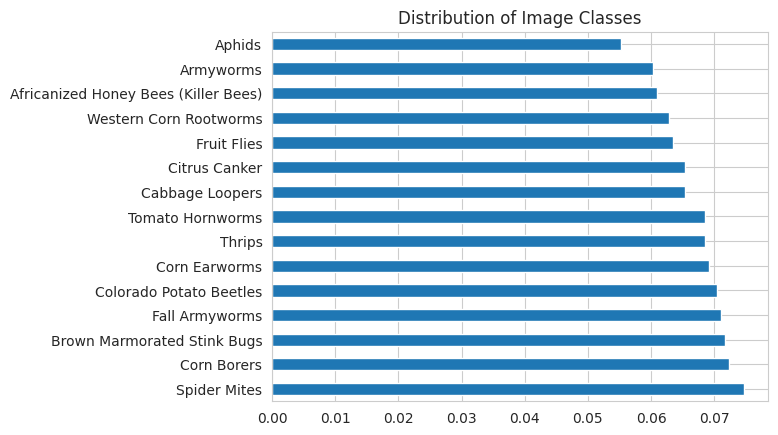

In [ ]:
images_df.image_label.value_counts(normalize=True).plot.barh()
plt.title("Distribution of Image Classes")
plt.show()

In [ ]:
#split images
train, test = train_test_split(images_df, test_size=0.2, random_state=0)
val, test = train_test_split(test, test_size=0.2, random_state=0)
print(f"""
training set: {train.shape[0]}
validation set: {val.shape[0]}
test set: {test.shape[0]}""")


training set: 1272
validation set: 255
test set: 64


In [ ]:
def convert_image_to_tensor(img_path: str) -> torch.Tensor:

    # read image as numpy array
    img = np.array(Image.open(img_path).convert("RGB")) / 255.

    # conver array to tensor
    to_tensor = transforms.ToTensor()
    img = to_tensor(img)

    # resize image to 224px by 224px
    resize = transforms.Resize((224, 224), antialias=True)
    img = resize(img)


    return img

In [ ]:
img2 = convert_image_to_tensor(images_df.loc[5]["image_path"])

In [ ]:
img2

tensor([[[0.9255, 0.9255, 0.9255,  ..., 0.9647, 0.9647, 0.9647],
         [0.9255, 0.9255, 0.9255,  ..., 0.9647, 0.9647, 0.9647],
         [0.9253, 0.9251, 0.9247,  ..., 0.9647, 0.9647, 0.9647],
         ...,
         [0.7699, 0.7570, 0.6290,  ..., 0.6645, 0.6558, 0.6387],
         [0.6851, 0.6638, 0.6414,  ..., 0.6554, 0.6451, 0.6327],
         [0.6563, 0.6235, 0.6612,  ..., 0.6475, 0.6395, 0.6333]],

        [[0.9333, 0.9333, 0.9333,  ..., 0.9765, 0.9765, 0.9765],
         [0.9333, 0.9333, 0.9333,  ..., 0.9765, 0.9765, 0.9765],
         [0.9335, 0.9337, 0.9340,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.8781, 0.8570, 0.7404,  ..., 0.7803, 0.7730, 0.7568],
         [0.8128, 0.7978, 0.7569,  ..., 0.7731, 0.7644, 0.7513],
         [0.7909, 0.7689, 0.7670,  ..., 0.7664, 0.7601, 0.7518]],

        [[0.9294, 0.9294, 0.9294,  ..., 0.9725, 0.9725, 0.9725],
         [0.9294, 0.9294, 0.9294,  ..., 0.9725, 0.9725, 0.9725],
         [0.9295, 0.9295, 0.9296,  ..., 0.9725, 0.9725, 0.

In [ ]:
from typing import Tuple, Union
def create_ds(image_data: Union[list, np.array]) -> np.array:
    ds = torch.empty((len(image_data),) + (3, 224, 224), dtype=torch.float32)

    for index, image in enumerate(image_data):
        ds[index] = image
    return ds

In [ ]:
train_image_list = [convert_image_to_tensor(image_path) for image_path in train.image_path.values]
val_image_list = [convert_image_to_tensor(image_path) for image_path in val.image_path.values]
test_image_list = [convert_image_to_tensor(image_path) for image_path in test.image_path.values]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
train_image_list

[tensor([[[0.2157, 0.2105, 0.2001,  ..., 0.3538, 0.3670, 0.3420],
          [0.2175, 0.2140, 0.2067,  ..., 0.3542, 0.3587, 0.3120],
          [0.2138, 0.2124, 0.2095,  ..., 0.3821, 0.3680, 0.3003],
          ...,
          [0.3372, 0.4412, 0.4638,  ..., 0.3378, 0.3248, 0.3314],
          [0.2700, 0.3070, 0.3634,  ..., 0.3476, 0.3321, 0.3354],
          [0.2399, 0.4446, 0.3665,  ..., 0.3269, 0.3209, 0.3276]],
 
         [[0.5835, 0.5783, 0.5680,  ..., 0.6901, 0.7025, 0.6836],
          [0.5766, 0.5732, 0.5658,  ..., 0.6840, 0.6946, 0.6574],
          [0.5706, 0.5693, 0.5663,  ..., 0.7145, 0.7063, 0.6455],
          ...,
          [0.6826, 0.7582, 0.7923,  ..., 0.7346, 0.7316, 0.7436],
          [0.6398, 0.6670, 0.7164,  ..., 0.7433, 0.7383, 0.7437],
          [0.6246, 0.7983, 0.7249,  ..., 0.7247, 0.7268, 0.7339]],
 
         [[0.2147, 0.2099, 0.1996,  ..., 0.1026, 0.1206, 0.0721],
          [0.2052, 0.2065, 0.2004,  ..., 0.1349, 0.1322, 0.0665],
          [0.1982, 0.1983, 0.1957,  ...,

In [ ]:
train_ds = create_ds(train_image_list)
val_ds = create_ds(val_image_list)
test_ds = create_ds(test_image_list)


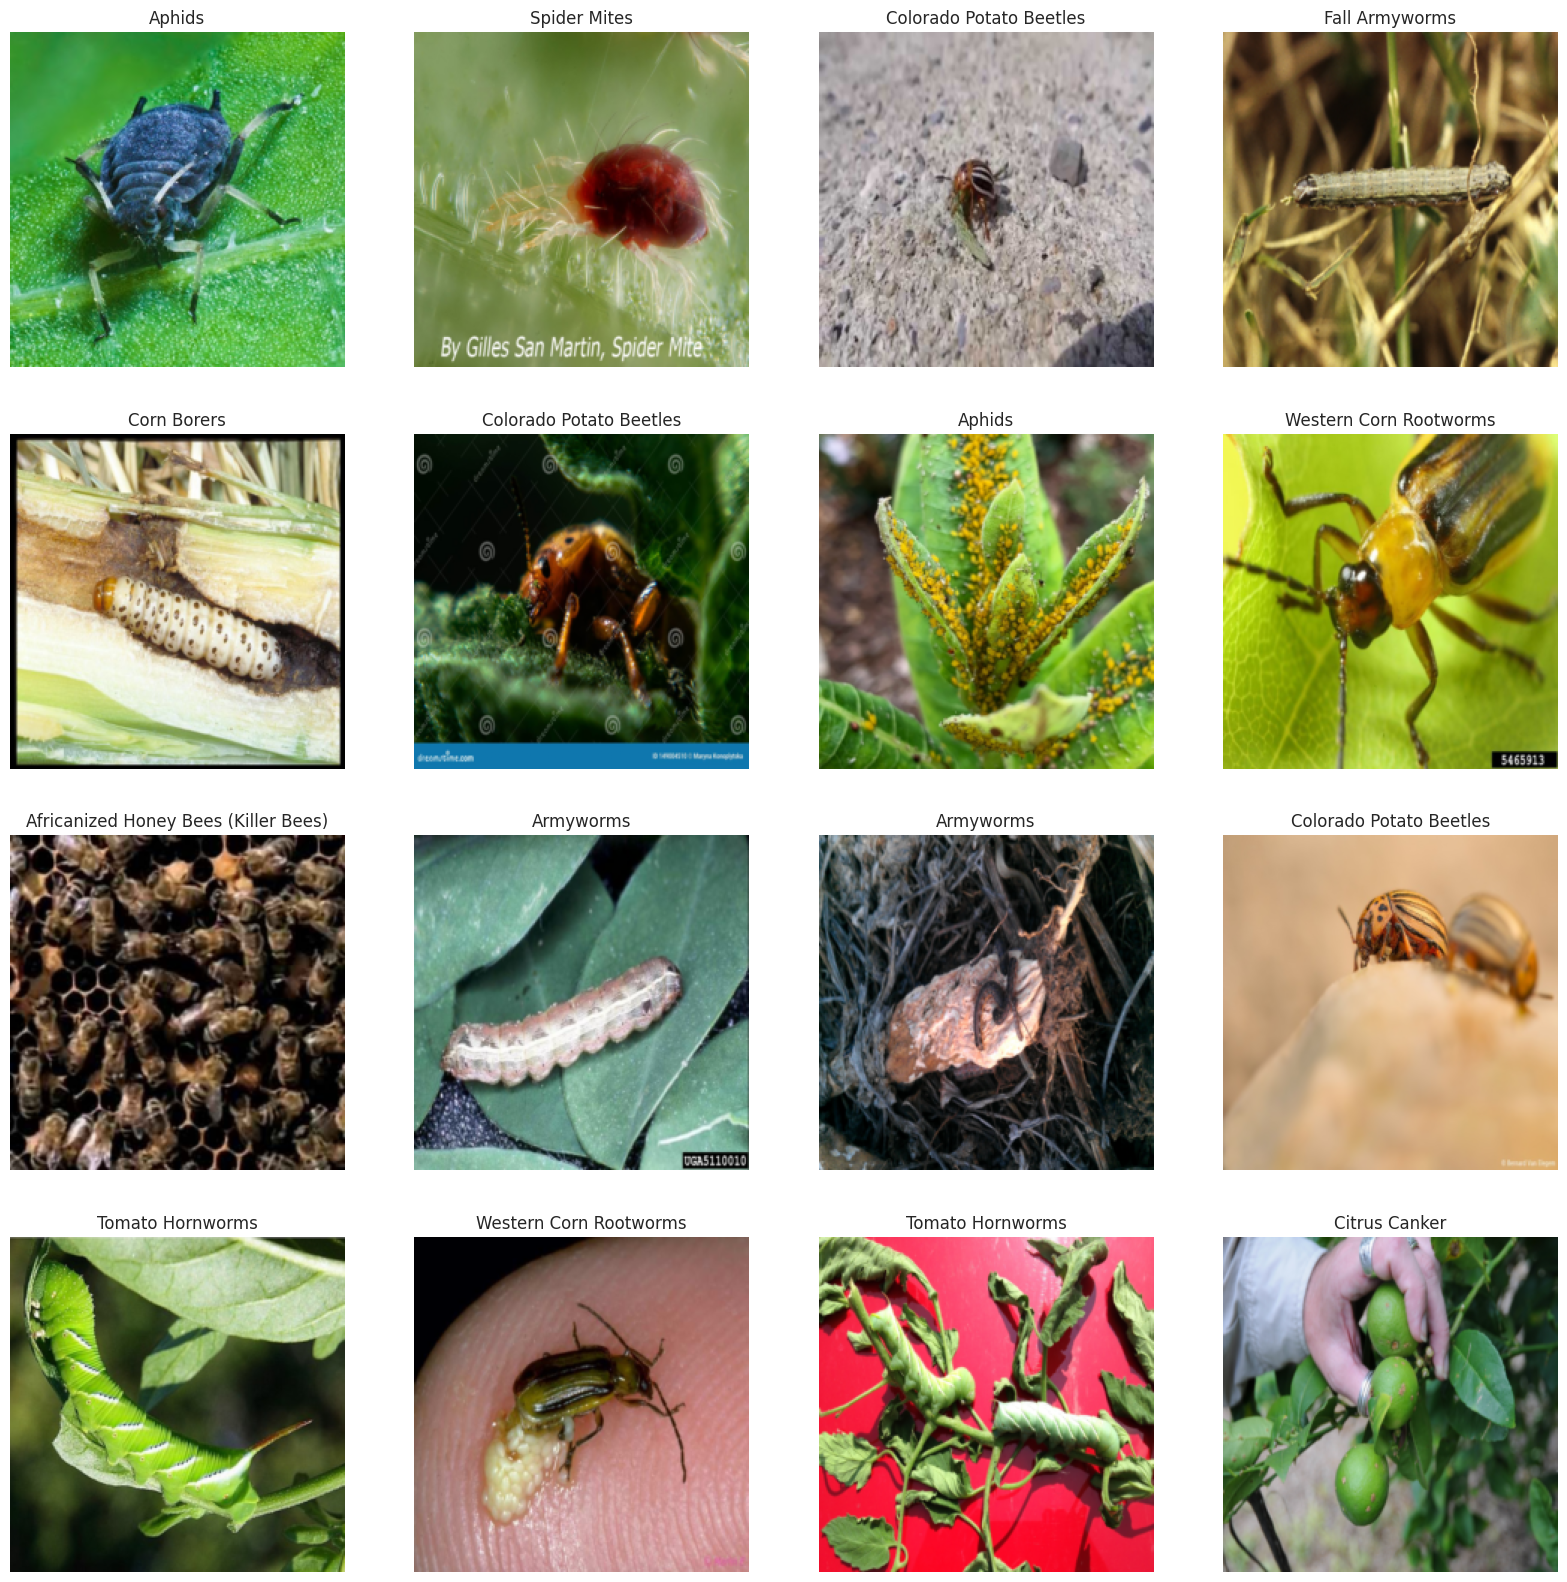

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for image, label, ax in zip(train_ds[:16], train.encoded_label[:16], axs.flat):
    ax.imshow(image.numpy().transpose(1,2,0))
    ax.set_title(encoder.inverse_transform([label])[0])
    ax.set_axis_off()

In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomPerspective(),
                                      transforms.RandomGrayscale()])

In [ ]:
train_X, train_y = DataLoader(train_ds, batch_size=32), DataLoader(torch.from_numpy(train.encoded_label.values), batch_size=32)
val_X, val_y = DataLoader(val_ds, batch_size=32), DataLoader(torch.from_numpy(val.encoded_label.values), batch_size=32)
test_X, test_y = DataLoader(test_ds, batch_size=32), DataLoader(torch.from_numpy(test.encoded_label.values), batch_size=32)


In [ ]:
data = DataLoader(
    datasets.ImageFolder(IMAGES_PATH, transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((224, 224), antialias=True)])),
    batch_size=32
    )

In [ ]:
batch = next(iter(data))

In [ ]:
def prepare_pretrained_resnet_model() -> models.resnet.ResNet:
    pretrained = models.resnet50(weights="IMAGENET1K_V1")
    for param in pretrained.parameters():
        param.requires_grad = False

    # new final layer with 15 classes
    num_ftrs = pretrained.fc.in_features
    pretrained.fc = torch.nn.Linear(num_ftrs, 15)

    return pretrained.cuda() if torch.cuda.is_available() else pretrained

In [ ]:
class CNNModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64,  kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 256)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 15)
        # self.fc3 = nn.Linear(256, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.fc3(x)
        return x


In [ ]:
resnet = prepare_pretrained_resnet_model()
type(resnet)

torchvision.models.resnet.ResNet

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train(train_X: Iterable, train_y: Iterable, model, optimizer: torch.optim, loss_fn: nn.modules.loss) -> Tuple[float, float]:
    train_accuracy = []
    losses = []

    for batch, (images, targets) in enumerate(zip(train_X, train_y)):
        optimizer.zero_grad()

        images = images.to(device)
        images = train_transforms(images)
        targets = targets.to(device)
        outputs = model(images.float())

        loss = loss_fn(outputs, targets)
        losses.append(np.expand_dims(loss.detach().cpu().numpy(), 0)[0])

        _, preds = torch.max(outputs.data, 1)
        accuracy = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
        train_accuracy.append(accuracy)

        loss.backward()
        optimizer.step()


    return np.array(losses).mean().round(4), np.array(train_accuracy).mean().round(4)



def validate(val_X: Iterable, val_y: Iterable,  model: CNNModel, loss_fn: nn.modules.loss) -> Tuple[float, float]:

    val_accuracy = []
    val_losses = []

    model.eval()
    with torch.no_grad():
        for batch, (images, targets) in enumerate(zip(val_X, val_y)):
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images.float())

            val_loss = loss_fn(outputs, targets)
            val_losses.append(np.expand_dims(val_loss.cpu().numpy(), 0)[0])

            _, preds = torch.max(outputs.data, 1)


            accuracy = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
            val_accuracy.append(accuracy)

        return np.array(val_losses).mean().round(4), np.array(val_accuracy).mean().round(4)





In [ ]:
EPOCHS = 100
model = resnet
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
early_stopping = EarlyStopper(patience=10, min_delta=0.001)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(EPOCHS):
    loss, train_acc = train(train_X, train_y, model, optimizer, loss_fn)
    val_loss, val_acc = validate(val_X, val_y, model, loss_fn)

    if early_stopping.early_stop(val_loss):
        break

    train_losses.append(loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch: {epoch}  loss - {loss}  train_accuracy - {train_acc},  val_loss - {val_loss}  val_accuracy - {val_acc}")
    print("==============================================================================================================================")



hist = pd.DataFrame({"loss": train_losses, "val_loss": val_losses, "train_accuracy": train_accuracies, "val_accuracy": val_accuracies})






Epoch: 0  loss - 2.7372000217437744  train_accuracy - 0.0773,  val_loss - 2.698499917984009  val_accuracy - 0.0983
Epoch: 1  loss - 2.711899995803833  train_accuracy - 0.087,  val_loss - 2.682800054550171  val_accuracy - 0.1098
Epoch: 2  loss - 2.683500051498413  train_accuracy - 0.1125,  val_loss - 2.6689999103546143  val_accuracy - 0.1376
Epoch: 3  loss - 2.664900064468384  train_accuracy - 0.1195,  val_loss - 2.6552999019622803  val_accuracy - 0.1535
Epoch: 4  loss - 2.6468000411987305  train_accuracy - 0.1198,  val_loss - 2.6414999961853027  val_accuracy - 0.1535
Epoch: 5  loss - 2.645400047302246  train_accuracy - 0.1292,  val_loss - 2.6273000240325928  val_accuracy - 0.1574
Epoch: 6  loss - 2.6210999488830566  train_accuracy - 0.1654,  val_loss - 2.6122000217437744  val_accuracy - 0.1692
Epoch: 7  loss - 2.5982000827789307  train_accuracy - 0.1904,  val_loss - 2.595900058746338  val_accuracy - 0.1928
Epoch: 8  loss - 2.591399908065796  train_accuracy - 0.2029,  val_loss - 2.58159

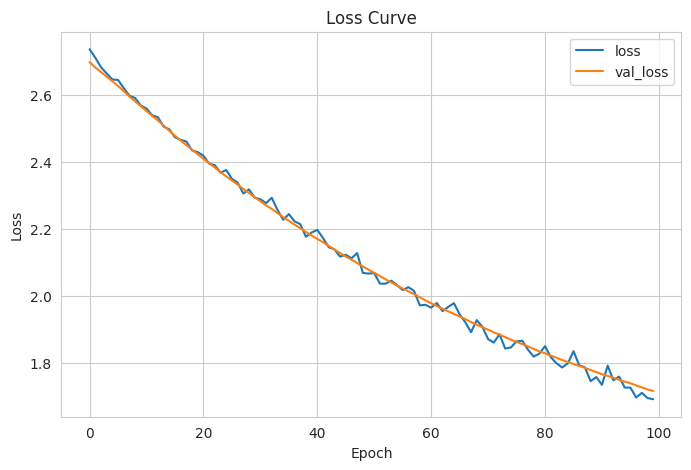

In [ ]:
plt.figure(figsize=(8, 5))
hist.loss.plot()
plt.title("Loss Curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
hist.val_loss.plot()
plt.legend()

plt.show()

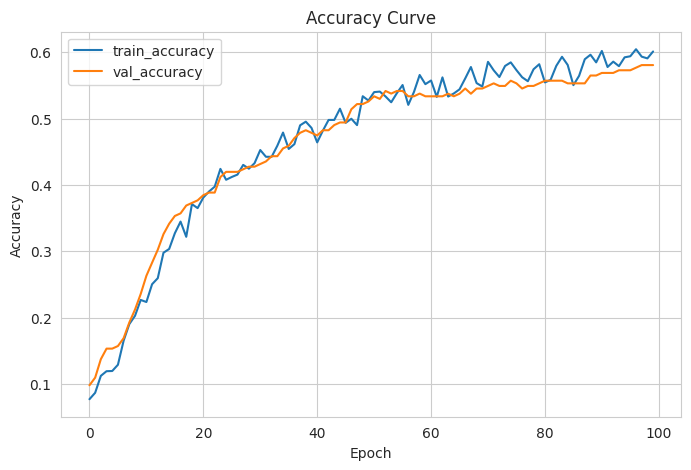

In [ ]:
plt.figure(figsize=(8, 5))

hist.train_accuracy.plot()
plt.title("Accuracy Curve")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
hist.val_accuracy.plot()
plt.legend()



plt.show()

In [ ]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for batch, (images, targets) in enumerate(zip(test_X, test_y)):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images.float())

        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(targets.cpu().numpy(), predicted.cpu().numpy())
        report = classification_report(targets.cpu().numpy(), predicted.cpu().numpy(), zero_division=0.0)

        print(accuracy)
        print(report)

0.40625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      0.50      0.50         4
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         4
           5       0.67      1.00      0.80         2
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.50      0.33      0.40         3
           9       0.00      0.00      0.00         0
          10       0.50      1.00      0.67         2
          11       0.33      0.33      0.33         3
          12       1.00      0.20      0.33         5
          13       0.50      1.00      0.67         2
          14       1.00      0.33      0.50         3

    accuracy                           0.41        32
   macro avg       0.37      0.38      0.32        32
weighted avg      

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/saved_models/farm_insects_model.pt"

torch.save(resnet.state_dict(), MODEL_PATH)